In [1]:
import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

import os
import argparse
import logging
import numpy as np
import pickle

import utils
class Args:
    def __init__(self):
        self.num_epochs=2
        self.batch_size=10
        self.train_all=True
        self.net = "resnet18"
        self.resume='./hw5_checkpoint.pth.tar'
        self.test_only=True
args = Args()

In [2]:
log_level = logging.INFO
logger = logging.getLogger()
logger.setLevel(log_level)
handler = logging.FileHandler("hw5.log")
handler.setLevel(log_level)
formatter = logging.Formatter('%(asctime)s - [%(levelname)s] - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.info("torch version: {}".format(torch.__version__))


# Hyper Parameters
batch_size = args.batch_size
pdist = nn.PairwiseDistance(p=2)
# Data Preparation

# note that mean and std is calculated channel-wise
# reference: https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/10
print("Data Preparation...")
logger.info("Data Preparation...")
transform_train = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


print("Loading Data...")
logger.info("Loading Data...")
img, label = utils.generate_testing_data_set()
test_dataset = utils.TinyImageNet(img, label, train=False, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

if args.test_only:
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=2,
                                              sampler=SubsetRandomSampler(range(8)))
print("Model setting...")
logger.info("Model setting...")

use_cuda = torch.cuda.is_available()
start_epoch = 0
if args.net == "resnet18":
    print("using resnet18")
    net = torchvision.models.resnet.ResNet(torchvision.models.resnet.BasicBlock, [2, 2, 2, 2])
    if not os.path.isfile(args.resume):
        net.load_state_dict(torch.load("../data/model/resnet18-5c106cde.pth"))
else:
    print("using resnet101")
    net = torchvision.models.resnet.ResNet(torchvision.models.resnet.Bottleneck, [3, 4, 23, 3])
    if not os.path.isfile(args.resume):
        net.load_state_dict(torch.load("../data/model/resnet101-5d3b4d8f.pth"))
# Do not change the layers that are pre-trained with the only exception
# on the last full-connected layer.
if not args.train_all:
    for param in net.parameters():
        param.requires_grad = False
# change the last fc layer for cifar100
net.fc = nn.Linear(in_features=net.fc.in_features, out_features=4096)

if use_cuda:
    net.cuda()
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    print(torch.cuda.device_count())
    cudnn.benchmark = True

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

criterion = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-06)
training_loss_seq = []
training_accuracy_seq = []
testing_accuracy_seq = []
testing_best_accuracy = 0

if args.resume:
    print("Resume from the checkpoint...")
    logger.info("Resume from the checkpoint...")
    if os.path.isfile(args.resume):
        print("=> loading checkpoint '{}'".format(args.resume))
        checkpoint = torch.load(args.resume)
        start_epoch = checkpoint['epoch'] + 1
        net.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        training_loss_seq = checkpoint['training_loss_seq']
        #training_accuracy_seq = checkpoint['training_accuracy_seq']
        testing_accuracy_seq = checkpoint['testing_accuracy_seq']
        testing_best_accuracy = checkpoint['testing_best_accuracy']
        print("=> loaded checkpoint '{}' (epoch {})"
              .format(args.resume, (checkpoint['epoch'] + 1)))
        logger.info("=> loaded checkpoint '{}' (epoch {})"
                    .format(args.resume, (checkpoint['epoch'] + 1)))
    else:
        print("=> no checkpoint found at '{}'".format(args.resume))
        logger.info("=> no checkpoint found at '{}'".format(args.resume))
        print("=> Training based on the resnet-101 from scratch...")
        logger.info("=> Training based on the resnet-101 from scratch...")
else:
    print("=> Training based on the resnet-18 from scratch...")
    logger.info("=> Training based on the resnet-18 from scratch...")


print("Model Training...")
logger.info("Model Training...")

# use up-to-date learning rate; for resume purpose
for param_group in optimizer.param_groups:
    current_learningRate = param_group['lr']


def train(epoch, k_closet=30):
    if args.test_only:
        k_closet = 3
        img_triplet, label_triplet = pickle.load(open("./pickle/train_1.p", 'rb'))
        train_dataset = utils.TinyImageNet(img_triplet, label_triplet, transform=transform_train)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5, num_workers=2,
                                                   shuffle=False, sampler=SubsetRandomSampler([0, 503, 1003, 1503, 2003, 2503, 3003, 3503, 4003, 4503]))
    else:
        if not os.path.isfile("./pickle/train_{}.p".format(epoch)):
            img_triplet, label_triplet = utils.generate_training_data_set(save=True, epoch_idx=epoch)
        else:
            img_triplet, label_triplet = pickle.load(open("./pickle/train_{}.p".format(epoch), 'rb'))
        train_dataset = utils.TinyImageNet(img_triplet, label_triplet, train=True, transform=transform_train)
        train_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=batch_size, shuffle=True, num_workers=32)

    global current_learningRate
    net.train()
    if (epoch+1) % 5 == 0:
        current_learningRate /= 2
        logger.info("=> Learning rate is updated!")
        utils.update_learning_rate(optimizer, current_learningRate)

    f_img_train = []
    label_train = []
    #train_bacth_accuracy = []
    loss_epoch = 0
    for _, (images, lables) in enumerate(train_loader):
        #start = time.time()
        if use_cuda:
            q, p, n, q_label = images[0].cuda(), images[1].cuda(), images[2].cuda(), lables[0].cuda()
        else:
            q, p, n, q_label = images[0], images[1], images[2], lables[0]
        optimizer.zero_grad()
        q, p, n = Variable(q), Variable(p), Variable(n)
        f_q, f_p, f_n = net(q), net(p), net(n)
        loss = criterion(f_q, f_p, f_n)
        loss.backward()
        optimizer.step()

        if torch.__version__ == '0.4.1':
            loss_epoch += loss.item()
            # print(loss_epoch)
        else:
            loss_epoch += loss.data[0]
            # print(loss_epoch)
        f_img_train.append(f_q)
        label_train.append(q_label)
        #end = time.time()
        #print("time for one batch {} s".format(end-start))
        # calculate train_acc so use train_loader as the test_loader
    #     train_accuracy = []
    #     for f_img_test_current, label_test_current in zip(f_q, q_label):
    #         f_img_test_current = f_img_test_current.reshape(1, 4096)
    #         f_img_test_current = f_img_test_current.expand(f_q.shape[0], 4096)
    #         distance = pdist(f_img_test_current, f_q)
    #         predicted = q_label[distance.topk(k_closet, largest=False)[1]]
    #         train_accuracy.append(float(torch.sum(torch.eq(predicted, label_test_current))) / k_closet)
    #     train_bacth_accuracy.append(np.mean(train_accuracy))
    # train_accuracy_epoch = np.mean(train_bacth_accuracy)

    f_img_train = torch.cat(f_img_train, dim=0)
    label_train = torch.cat(label_train, dim=0)

    # train_accuracy = []
    # # calculate train_acc so use train_loader as the test_loader
    # for f_img_test_current, label_test_current in zip(f_img_train, label_train):
    #     f_img_test_current = f_img_test_current.reshape(1, 4096)
    #     f_img_test_current = f_img_test_current.expand(f_img_train.shape[0], 4096)
    #     distance = pdist(f_img_test_current, f_img_train)
    #     predicted = label_train[distance.topk(k_closet)[1]]
    #     train_accuracy.append(float(torch.sum(torch.eq(predicted, label_test_current))) / k_closet)
    # train_accuracy_epoch = np.mean(train_accuracy)

    # print("=> Epoch: [{}/{}] | Loss:[{}] | Training Accuracy: [{}]".format(epoch + 1, args.num_epochs, loss_epoch, train_accuracy_epoch))
    # logger.info("=> Epoch: [{}/{}] | Loss:[{}] | Training Accuracy: [{}]".format(epoch + 1, args.num_epochs, loss_epoch, train_accuracy_epoch))
    # return loss_epoch, train_accuracy_epoch, f_img_train, label_train
    print("=> Epoch: [{}/{}] | Loss:[{}]".format(epoch + 1, args.num_epochs, loss_epoch))
    logger.info("=> Epoch: [{}/{}] | Loss:[{}]".format(epoch + 1, args.num_epochs, loss_epoch))
    return loss_epoch, f_img_train, label_train


def test(epoch, f_img_train, label_train, k_closet=30):
    net.eval()
    if args.test_only:
        k_closet = 3
    # f_img_train = []
    # label_train = []
    # for _, (imgs_train, labels_train) in enumerate(train_loader):
    #     if use_cuda:
    #         imgs_train, labels_train = imgs_train.cuda(), labels_train.cuda()
    #     f_img_train.append(net(imgs_train[0]))
    #     label_train.append(labels_train[0])
    # f_img_train = torch.cat(f_img_train, dim=0)
    # label_train = torch.cat(label_train, dim=0)

    # f_img_test = []
    # label_test = []
    # for _, (imgs_test, labels_test) in enumerate(test_loader):
    #     if use_cuda:
    #         imgs_test, labels_test = imgs_test.cuda(), labels_test.cuda()
    #     #f_img_test, label_test = Variable(f_img_test), Variable(label_test)
    #     f_img_test.append(net(imgs_test))
    #     label_test.append(labels_test)

    # f_img_test = torch.cat(f_img_test, dim=0)
    # label_test = torch.cat(label_test, dim=0)

    # test_accuracy = []
    # for f_img_test_current, label_test_current in zip(f_img_test, label_test):
    #     f_img_test_current = f_img_test_current.reshape(1, 4096)
    #     f_img_test_current = f_img_test_current.expand(f_img_train.shape[0], 4096)
    #     distance = pdist(f_img_test_current, f_img_train)
    #     predicted = label_train[distance.topk(k_closet)[1]]
    #     test_accuracy.append(float(torch.sum(torch.eq(predicted, label_test_current))) / k_closet)
    # test_accuracy_epoch = np.mean(test_accuracy)

    test_accuracy = []
    for _, (imgs_test, labels_test) in enumerate(test_loader):
        if use_cuda:
            imgs_test, labels_test = imgs_test.cuda(), labels_test.cuda()
        imgs_test = Variable(imgs_test)
        with torch.no_grad():
            f_img_test = net(imgs_test)
        for f_img_test_current, label_test_current in zip(f_img_test, labels_test):
            f_img_test_current = f_img_test_current.reshape(1, 4096)
            f_img_test_current = f_img_test_current.expand(f_img_train.shape[0], 4096)
            distance = pdist(f_img_test_current, f_img_train)
            predicted = label_train[distance.topk(k_closet)[1]]
            test_accuracy.append(float(torch.sum(torch.eq(predicted, label_test_current))) / k_closet)
    test_accuracy_epoch = np.mean(test_accuracy)

    print("=> Epoch: [{}/{}] | Testing Accuracy: [{}]".format(
        epoch + 1, args.num_epochs, test_accuracy_epoch))
    logger.info("=> Epoch: [{}/{}] | Testing Accuracy: [{}]".format(
        epoch + 1, args.num_epochs, test_accuracy_epoch))

    return test_accuracy_epoch


for epoch in range(start_epoch, args.num_epochs):
    #train_loss, train_accuracy, f_img_train, label_train = train(epoch)
    train_loss, f_img_train, label_train = train(epoch)
    f_img_train = f_img_train.detach()
    # if (epoch+1) % 2 == 0:
    test_accuracy = test(epoch, f_img_train, label_train)
    training_loss_seq.append(train_loss)
    # training_accuracy_seq.append(train_accuracy)
    testing_accuracy_seq.append(test_accuracy)

    is_best = testing_accuracy_seq[-1] > testing_best_accuracy
    testing_best_accuracy = max(testing_best_accuracy, testing_accuracy_seq[-1])

    state = {
        "epoch": epoch,
        "state_dict": net.state_dict(),  # if use_cuda else net.module.state_dict()
        "optimizer": optimizer.state_dict(),
        "training_loss_seq": training_loss_seq,
        # "training_accuracy_seq": training_accuracy_seq,
        "testing_accuracy_seq": testing_accuracy_seq,
        "testing_best_accuracy": testing_best_accuracy
    }
    utils.save_checkpoint(state, is_best, filename='checkpoint.pth.tar', extra="hw5_")
    if is_best:
        logger.info("=> Best parameters are updated")


logger.info("=> Trained on [{}] epoch, with test accuracy [{}].\n \
 During the training stages, historical best test accuracy is \
 [{}]".format(args.num_epochs, testing_accuracy_seq[-1], testing_best_accuracy))
print("=> Trained on [{}] epoch, with test accuracy [{}].\n \
 During the training stages, historical best test accuracy is \
 [{}]".format(args.num_epochs, testing_accuracy_seq[-1], testing_best_accuracy))


Data Preparation...
Loading Data...
Model setting...
using resnet18
Resume from the checkpoint...
=> loading checkpoint './hw5_checkpoint.pth.tar'
=> loaded checkpoint './hw5_checkpoint.pth.tar' (epoch 2)
Model Training...
=> Trained on [2] epoch, with test accuracy [0.0].
  During the training stages, historical best test accuracy is  [0]


In [3]:
# img_triplet, label_triplet = pickle.load(open("./pickle/train_{}.p".format(2), 'rb'))
# train_dataset = utils.TinyImageNet(img_triplet, label_triplet, train=True, transform=transform_train)
# train_loader = torch.utils.data.DataLoader(train_dataset,
#                                                 batch_size=batch_size, shuffle=True, num_workers=32)
# f_img_train = []
# label_train = []
# for idx, (images, lables) in enumerate(train_loader):
#     if idx % 100 == 0:
#         print(idx)
#     if use_cuda:
#             q = images[0].cuda()
#     else:
#         q, q_label = images[0], lables[0]
#     with torch.no_grad():
#         q = Variable(q)
#         f_q = net(q)
#     f_img_train.append(f_q)
#     label_train.append(q_label)

In [1]:
import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

import os
import argparse
import logging
import numpy as np
import pickle
import time
import utils
class Args:
    def __init__(self):
        self.num_epochs=2
        self.batch_size=10
        self.train_all=True
        self.net = "resnet18"
        self.resume='./hw5_checkpoint.pth.tar'
        self.test_only=True
args = Args()

net = torchvision.models.resnet.ResNet(torchvision.models.resnet.BasicBlock, [2, 2, 2, 2])
net.fc = nn.Linear(in_features=net.fc.in_features, out_features=4096)
train_checkpoint = torch.load("./train_checkpoint_{}.pth".format(4), map_location='cpu')
state_dict = train_checkpoint["state_dict"]
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
net.load_state_dict(new_state_dict)

In [2]:
batch_size = args.batch_size
pdist = nn.PairwiseDistance(p=2)
# Data Preparation

# note that mean and std is calculated channel-wise
# reference: https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/10
print("Data Preparation...")
transform_train = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


img_triplet, label_triplet = pickle.load(open("./pickle/train_{}.p".format(2), 'rb'))
train_dataset = utils.TinyImageNet(img_triplet, label_triplet, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5, num_workers=2,
                                           shuffle=False, sampler=SubsetRandomSampler(range(5000))) 
# [0, 1,2,3,
# 503, 1003, 1503, 
# 2003, 2004, 2005 ,
# 2503, 3003, 3503, 4003, 4503]

Data Preparation...


In [3]:
img, label = utils.generate_testing_data_set()
test_dataset = utils.TinyImageNet(img, label, train=False, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=2,
                                              sampler=SubsetRandomSampler([23, 68, 50, 70, 77, 249]))

In [4]:
def test(epoch, train_loader, k_closet=30, use_cuda=False):
    net.eval()
    if args.test_only:
        k_closet = 3
    f_img_train = []
    label_train = []
    test_accuracy = []
    with torch.no_grad():
        start = time.time()
        print("Calculate Training Feature Embedding...")
        for _, (images, lables) in enumerate(train_loader):
            if use_cuda:
                q, q_label = images[0].cuda(), lables[0].cuda()
            else:
                q, q_label = images[0], lables[0]
            q = Variable(q)
            f_q = net(q)
            f_img_train.append(f_q)
            label_train.append(q_label)
        f_img_train = torch.cat(f_img_train, dim=0)
        label_train = torch.cat(label_train, dim=0)
        end = time.time()
        print("Finish in {} min".format((end-start)/60))
        print("Testing...")
        for _, (imgs_test, labels_test) in enumerate(test_loader):
            if use_cuda:
                imgs_test, labels_test = imgs_test.cuda(), labels_test.cuda()
            imgs_test = Variable(imgs_test)
            f_img_test = net(imgs_test)
            for f_img_test_current, label_test_current in zip(f_img_test, labels_test):
                f_img_test_current = f_img_test_current.reshape(1, 4096)
                f_img_test_current = f_img_test_current.expand(f_img_train.shape[0], 4096)
                distance = pdist(f_img_test_current, f_img_train)
                predicted = label_train[distance.topk(k_closet, largest=False)[1]]
                test_accuracy.append(float(torch.sum(torch.eq(predicted, label_test_current))) / k_closet)
        test_accuracy_epoch = np.mean(test_accuracy)

        print("=> Epoch: [{}/{}] | Testing Accuracy: [{}]".format(
            epoch + 1, args.num_epochs, test_accuracy_epoch))
    return test_accuracy_epoch

In [5]:
test_accuracy = test(0, train_loader, k_closet=5)

Calculate Training Feature Embedding...
Finish in 7.589399047692617 min
Testing...
=> Epoch: [1/2] | Testing Accuracy: [0.4444444444444444]


In [25]:
import torchvision.models as models
resnet18 = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /Users/ym/.torch/models/resnet50-19c8e357.pth
100.0%


In [1]:
import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

import os
import argparse
import logging
import numpy as np
import pickle
import time
import utils
net = torchvision.models.resnet.ResNet(torchvision.models.resnet.Bottleneck, [3, 4, 6, 3])
net.fc = nn.Linear(in_features=net.fc.in_features, out_features=4096)

In [3]:
check = torch.load("./checkpoint.pth.tar",map_location='cpu')

In [7]:
state_dict = check["state_dict"]

In [15]:
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[13:] # remove `module.`
    new_state_dict[name] = v

In [16]:
net.load_state_dict(new_state_dict)

In [19]:
img, label = utils.generate_testing_data_set()

In [26]:
transform_test = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
])

img, label = utils.generate_testing_data_set()
val_img, val_label = img[0:4], label[0:4]
test_dataset = utils.TinyImageNet(val_img, val_label, train=False, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=32)
# f_img_train, label_train = pickle.load(open("./pickle/resnet50_embedding_{}.p".format(epoch), 'rb'))

0 torch.Size([1, 3, 224, 224]) tensor([107])
1 torch.Size([1, 3, 224, 224]) tensor([139])
2 torch.Size([1, 3, 224, 224]) tensor([140])
3 torch.Size([1, 3, 224, 224]) tensor([69])


In [2]:
transform_train = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
img_triplet, label_triplet = pickle.load(open("./pickle/train_{}.p".format(0), 'rb'))
train_dataset = utils.TinyImageNet(img_triplet, label_triplet, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, num_workers=32, shuffle=False)

In [3]:
for idx, (img, label) in enumerate(train_loader):
    q, q_label = img[0], label[0]
    if idx <= 10:
        print(idx, q.shape, q_label)
    else:
        break

0 torch.Size([10, 3, 224, 224]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
1 torch.Size([10, 3, 224, 224]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
2 torch.Size([10, 3, 224, 224]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
3 torch.Size([10, 3, 224, 224]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
4 torch.Size([10, 3, 224, 224]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
5 torch.Size([10, 3, 224, 224]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
6 torch.Size([10, 3, 224, 224]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
7 torch.Size([10, 3, 224, 224]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
8 torch.Size([10, 3, 224, 224]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
9 torch.Size([10, 3, 224, 224]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
10 torch.Size([10, 3, 224, 224]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [130]:
import utils
train_dict, db = utils.create_database()
img_all = [db[i] for i in db.keys()]
img_all = [item for l in img_all for item in l]
img, label = utils.generate_testing_data_set()

In [74]:
top10, bottom10 = torch.load("./final.pth",map_location='cpu')
q_num = 0 

In [144]:
idx = bottom10["idx_of_fig_path_bottom10"][q_num].numpy()
path = [img_all[i] for i in idx]

In [103]:
img[0], label[0]

('../data/tiny-imagenet-200/val/images/val_0.JPEG', 107)

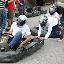

In [101]:
from PIL import Image
Image.open(img[0])

In [145]:
path

['../data/tiny-imagenet-200/train/n03617480/images/n03617480_13.JPEG',
 '../data/tiny-imagenet-200/train/n04146614/images/n04146614_267.JPEG',
 '../data/tiny-imagenet-200/train/n03617480/images/n03617480_459.JPEG',
 '../data/tiny-imagenet-200/train/n02410509/images/n02410509_43.JPEG',
 '../data/tiny-imagenet-200/train/n02410509/images/n02410509_118.JPEG',
 '../data/tiny-imagenet-200/train/n02410509/images/n02410509_56.JPEG',
 '../data/tiny-imagenet-200/train/n04146614/images/n04146614_366.JPEG',
 '../data/tiny-imagenet-200/train/n03617480/images/n03617480_132.JPEG',
 '../data/tiny-imagenet-200/train/n03617480/images/n03617480_109.JPEG',
 '../data/tiny-imagenet-200/train/n04146614/images/n04146614_161.JPEG']

In [199]:
mytop10 = {"path":[], "distance":[], "label":[]}
count = 0
for j in [0,21,674, 975, 2001]:
    query_fig_idx = label[j]
    n_label = [i for i in train_dict.keys()][query_fig_idx]
    mytop10["path"].append(db[n_label][:11])
    mytop10["distance"].append(top10['distance_of_top10'][count])
    mytop10["label"].append([n_label]*10)
    count += 1

In [210]:
mybottom10 = {"path":[], "distance":[], "label":[]}
count = 0
for j in [0,21,674, 975, 2001]:
    #idx = bottom10["idx_of_fig_path_bottom10"][count].numpy()
    path = [img_all[i] for i in np.random.choice(range(100000), 10)]
    mybottom10["path"].append(path)
    mybottom10["distance"].append(bottom10['distance_of_bottom10'][count])
    mybottom10["label"].append([path[i].split("/")[4] for i in range(10)])
    count += 1

In [211]:
query_list = {"path":[], "label":[]}
for j in [0,21,674, 975, 2001]:
    query_fig_idx = label[j]
    n_label = [i for i in train_dict.keys()][query_fig_idx]
    query_list["path"].append(img[j])
    query_list["label"].append([n_label])

In [214]:
pickle.dump((query_list, mytop10, mybottom10, loss), file=open("./myfinal.p", "wb"))

In [208]:
img_all[1]

'../data/tiny-imagenet-200/train/n01443537/images/n01443537_1.JPEG'

In [209]:
np.random.choice(range(100000), 10)

array([40825, 49356, 15676, 76158, 38019, 61038, 30206, 10029, 55442,
       86817])

In [213]:
loss = [0.023586829798318505, 0.013265381048618964, 0.011313620450353156 ,0.010403190940040876,0.008552217199533916,0.007924619082339705,0.007454473718487061,0.0070725912862916445, 0.006998448625764722, 0.006250378639476185, 0.005731241940571726, 0.005593074555785206,0.0054566194354433535, 0.005245383240342053,0.005068134553935561]